In [1]:
import pandas as pd
import numpy as np

import cv2
import glob
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# function to read images from path. results are numpy arrays
def read_images(path):
    return [cv2.imread(file) for file in glob.glob(path)]

In [3]:
# function to read images from path. results are images
def read_images2(path):
    return [Image.open(file) for file in glob.glob(path)]

In [4]:
path_y = './brain-mri-images-for-brain-tumor-detection/yes/*'
path_n = './brain-mri-images-for-brain-tumor-detection/no/*'

images_y = read_images2(path_y)
images_n = read_images2(path_n)

In [5]:
def show_images(img1, img2):
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title('Brain with tumor')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title('Brain without tumor')

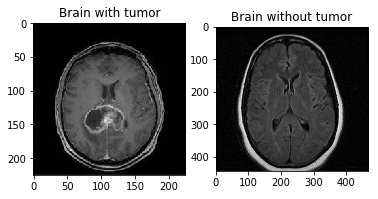

In [6]:
show_images(images_y[0], images_n[0])

In [7]:
# sqaring images function:
# desired_size: a square which side is the max between original base and height
# creates a black image with desired size
# pastes the original image in the center of the new image
def square_image(list_of_images):
    res = []
    for img in list_of_images:
        desired_size = (max(img.size), max(img.size))
        position = int(max(img.size)/2) - int(min(img.size)/2) 
        sq_img = Image.new("RGB", desired_size, color='black')
        if img.size[0] < img.size[1]:
            sq_img.paste(img, (0, position))
        else:
            sq_img.paste(img, (position, 0))
        res.append(sq_img)
    return res

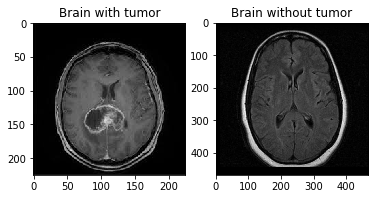

In [9]:
images_y_sq = square_image(images_y)
images_n_sq = square_image(images_n)
show_images(images_y_sq[0], images_n_sq[0])

In [17]:
# now we want to reshape all the images to 256x256
def resize_images(list_of_images, size=256):
    return [img.resize((size,size)) for img in list_of_images]

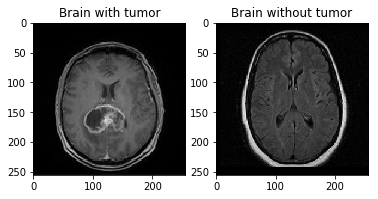

In [18]:
images_y_sq_rs = resize_images(images_y_sq)
images_n_sq_rs = resize_images(images_n_sq)
show_images(images_y_sq_rs[0], images_n_sq_rs[0])

In [21]:
# now we start to use open cv library, that works with numpy arrays instead of images
def image_to_nparray(list_of_images):
    return [np.array(img) for img in list_of_images]

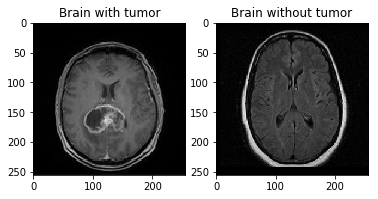

In [22]:
images_y_sq_rs_np = image_to_nparray(images_y_sq_rs)
images_n_sq_rs_np = image_to_nparray(images_n_sq_rs)
show_images(images_y_sq_rs_np[0], images_n_sq_rs_np[0])

In [ ]:
# function to get gray scale images
def img_to_gray_scale(list_of_images):
    return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in list_of_images]

In [ ]:
images_y_gray = img_to_gray_scale(images_y)
images_n_gray = img_to_gray_scale(images_n)
show_images(images_y_gray[0], images_n_gray[0])

In [ ]:
def median_filter(list_of_images):
    return [cv2.medianBlur(img,9) for img in list_of_images]

In [ ]:
# function to transform list of images to b&w
# I get the element 1 because it returs a tuple (threshold, image)
# meaning of the threshold: 0 is black, 255 is white, so I set that the pixels which are below 127
# turn black, and the ones that are above 127 turn white
def images_to_bw(list_of_images):
    return [cv2.threshold(img, 135, 255, cv2.THRESH_BINARY)[1] for img in list_of_images]

In [ ]:
images_yes_mf = median_filter(images_yes)
images_no_mf = median_filter(images_no)

In [ ]:
plt.imshow(images_yes_mf[1])

In [ ]:
images_yes_bw = images_to_bw(images_yes_mf)
images_no_bw = images_to_bw(images_no_mf)

In [ ]:
plt.imshow(images_yes_bw[1])

In [ ]:
plt.imshow(images_no_bw[1])

In [ ]:
#img = images_yes_bw[1]
#img = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
#img = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

In [ ]:
# plt.imshow(img)